In [11]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import matplotlib.pyplot as plt

from src.models.decision_transformer import DecisionTransformer
from src.data.dataset import RecommendationDataset
from src.training.trainer import *

import numpy as np
import torch as T
from torch.utils.data import DataLoader

In [12]:
# Set up device
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    T.manual_seed(seed)
    if T.cuda.is_available():
        T.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda


# Entrenamiento del Decision Transformer para Recomendación (DT4REC)

Este notebook documenta el pipeline de entrenamiento del Decision Transformer adaptado a recomendación de ítems. Describe las entradas (trayectorias preprocesadas), la arquitectura usada, los hiperparámetros, el loop de entrenamiento y la evaluación comparativa con un código de referencia.

### Carga de trayectorias

Cargamos las trayectorias previamente preprocesadas. Cada elemento en `trajectories` es una trayectoria con tensores para estados, acciones, `returns_to_go` (rtg), timesteps y group id. Hay dos versiones disponibles:
- `normalized_trajectories_train.pkl`: recompensas normalizadas (útil para estabilizar el entrenamiento).
- `trajectories_train.pkl`: recompensas en escala original (útil para análisis sin escalado).

Al alternar entre ambas se puede comprobar el efecto de la normalización sobre la convergencia y la magnitud de las pérdidas.

In [2]:
load_normalized_trayectories = True

if load_normalized_trayectories:
    with open('../data/processed/normalized_trajectories_train.pkl', 'rb') as f:
        trajectories = pickle.load(f)
else:
    with open('../data/processed/trajectories_train.pkl', 'rb') as f:
        trajectories = pickle.load(f)

### Configuración de Hiperparámetros

Definimos los hiperparámetros principales utilizados para instanciar el modelo y entrenarlo. Notas rápidas:
- `num_items`: número total de ítems (vocabulario del embedding).
- `hidden_dim`: dimensión de las representaciones internas del Transformer.
- `n_layers`, `n_heads`: profundidad y atención múltiple del Transformer.
- `context_length`: número de pasos de historial que el modelo observa por ejemplo.
- `batch_size`, `learning_rate`context_length: parámetros de optimización que afectan la estabilidad y velocidad de convergencia.

Estos valores son los que se usaron en pruebas previas y sirven como punto de partida; ajustar `hidden_dim`, `n_layers` y `learning_rate` es lo más habitual para buscar mejor rendimiento o menor sobreajuste.

In [ ]:
# Hyperparameters
num_items = 752
num_groups = 8
hidden_dim = 256
n_layers = 2
n_heads = 4
context_length = 20
max_timesteps = 200
dropout = 0.2
batch_size = 32
num_epochs = 1000
learning_rate = 0.0001

# 2.1 Arquitectura del modelo

El `DecisionTransformer` combina embeddings para estados, recompensas (`rtg`) y acciones con bloques Transformer autoregresivos para predecir la siguiente acción (ítem). La arquitectura está diseñada para operar sobre trayectorias de longitud variable y puede condicionarse por la recompensa objetivo.

### Inicialización del modelo

Instanciamos `DecisionTransformer` con los hiperparámetros definidos. Verificamos que el modelo se coloque en el `device` correcto (CPU/GPU) y mostramos el número total de parámetros para estimar coste de memoria y cómputo.

In [4]:
# Inicialización del modelo
model = DecisionTransformer(
    num_items=num_items,
    num_groups=num_groups,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to(device)

# Número de parámetros del modelo
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 2,212,848


### Preparación de datos para entrenamiento

Construimos instancias de `RecommendationDataset` a partir de las trayectorias para generar batches con `states`, `actions`, `rtg`, `timesteps`, `groups` y `targets` ya en tensores listos para el modelo. Separamos manualmente un 10% para validación. 

Observaciones:
- `random_start=True` en entrenamiento ayuda a la generalización al usar ventanas aleatorias de la trayectoria.
- `random_start=False` en validación garantiza evaluaciones reproducibles.
- Comprobar shapes de batch es útil para detectar desajustes antes de entrenar.

In [5]:
# Split trajectories manually to create different datasets
val_ratio = 0.1
n_total = len(trajectories)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# Shuffle trajectories before splitting (optional but good practice)
# np.random.shuffle(trajectories) # Assuming trajectories is a list

train_trajectories = trajectories[:n_train]
val_trajectories = trajectories[n_train:]

train_dataset = RecommendationDataset(
    trajectories=train_trajectories, 
    context_length=context_length, 
    random_start=True
)

val_dataset = RecommendationDataset(
    trajectories=val_trajectories, 
    context_length=context_length, 
    random_start=False
)

print(f"Number of training trajectories: {len(train_trajectories)}")
print(f"Number of validation trajectories: {len(val_trajectories)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print("\nDataset details:")
print(f"Dataset train size: {len(train_dataset)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"Dataset val size: {len(val_dataset)}")
print(f"Batches per epoch (val): {len(val_loader)}")

# Para testear los shapes de los batches
# sample_batch = next(iter(train_loader))
# print(f"\nSample batch shapes:")
# for key, val in sample_batch.items():
#     print(f"  {key}: {val.shape}")

# Nueva celda para debug
sample_batch = next(iter(train_loader))
states = sample_batch['states'].to(device)
actions = sample_batch['actions'].to(device)
rtg = sample_batch['rtg'].to(device)
timesteps = sample_batch['timesteps'].to(device)
groups = sample_batch['groups'].to(device)

print(f"rtg shape antes de embedding: {rtg.shape}, dtype: {rtg.dtype}")
print(f"rtg_embedding input shape: {rtg.shape}")

# Test embedding manual
rtg_test = model.rtg_embedding(rtg)
print(f"rtg_emb shape después de embedding: {rtg_test.shape}")
print(f"rtg_emb ndim: {rtg_test.ndim}")

# Verifica qué es rtg_embedding
print(f"rtg_embedding layer: {model.rtg_embedding}")


Number of training trajectories: 14400
Number of validation trajectories: 1600

Dataset details:
Dataset train size: 14400
Batches per epoch (train): 450
Dataset val size: 1600
Batches per epoch (val): 50
rtg shape antes de embedding: torch.Size([32, 20, 1]), dtype: torch.float32
rtg_embedding input shape: torch.Size([32, 20, 1])
rtg_emb shape después de embedding: torch.Size([32, 20, 256])
rtg_emb ndim: 3
rtg_embedding layer: Linear(in_features=1, out_features=256, bias=True)


In [6]:
optimizer = T.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# 2.2 Training Loop

A continuación se proporciona el loop de entrenamiento que optimiza la función de pérdida para predecir la acción siguiente. El entrenamiento incluye:
- forward pass y cálculo de la pérdida (cross-entropy).
- backward pass y step del optimizador.
- evaluación periódica sobre el set de validación.

El código real de entrenamiento puede llevar mucho tiempo si no se dispone de GPU; por ello el notebook también ofrece la opción de cargar pesos ya entrenados para análisis y comparación.

En muchos entornos de desarrollo dejamos el entrenamiento completo comentado para evitar ejecuciones largas. Si se desea entrenar localmente:
- ajuste `num_epochs`, `batch_size` y `learning_rate` según recursos disponibles,
- habilite `checkpoint_dir` para guardar puntos intermedios y reanudar entrenamientos largos,
- utilice `T.save` para persistir el mejor modelo según la métrica de validación.

In [ ]:
model, history = train_decision_transformer(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=1000,
    checkpoint_dir="checkpoints"
)

  ✔ Checkpoint guardado: checkpoints\dt_epoch1_val6.6693.pt
Epoch 1/1000
  Train Loss: 6.6721
  Val   Loss: 6.6693
  ✔ Checkpoint guardado: checkpoints\dt_epoch11_val6.6486.pt
Epoch 11/1000
  Train Loss: 6.5994
  Val   Loss: 6.6486
Epoch 21/1000
  Train Loss: 6.4767
  Val   Loss: 6.6796
Epoch 31/1000
  Train Loss: 6.3388
  Val   Loss: 6.7201
Epoch 41/1000
  Train Loss: 6.1505
  Val   Loss: 6.7910
Epoch 51/1000
  Train Loss: 5.9319
  Val   Loss: 6.9265
Epoch 61/1000
  Train Loss: 5.7251
  Val   Loss: 7.0594
Epoch 71/1000
  Train Loss: 5.5521
  Val   Loss: 7.2069
Epoch 81/1000
  Train Loss: 5.4119
  Val   Loss: 7.2824
Epoch 91/1000
  Train Loss: 5.2938
  Val   Loss: 7.4393
Epoch 101/1000
  Train Loss: 5.2086
  Val   Loss: 7.4899
Epoch 111/1000
  Train Loss: 5.1222
  Val   Loss: 7.6861
Epoch 121/1000
  Train Loss: 5.0558
  Val   Loss: 7.8293
Epoch 131/1000
  Train Loss: 4.9958
  Val   Loss: 7.9871
Epoch 141/1000
  Train Loss: 4.9356
  Val   Loss: 7.9820
Epoch 151/1000
  Train Loss: 4.9015

In [ ]:
import datetime

# Guardamos el modelo entrenado
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
T.save(model.state_dict(), f'trained_model_{date}.pt')
print(f"Model saved to 'trained_model_{date}.pt'")

# Guardamos el historial de entrenamiento
with open(f'training_history_{date}.pkl', 'wb') as f:
    pickle.dump(history, f)
print(f"Training history saved to 'training_history_{date}.pkl'")

Model saved to 'trained_model_2025-12-08_12-40-52.pt'
Training history saved to 'training_history_2025-12-08_12-40-52.pkl'


# 2.3 Data Loss

En esta sección cargamos historiales de entrenamiento y graficamos `train_loss` y `val_loss` comparando el código refactorizado con el código de referencia. Estas curvas permiten detectar:
- sobreajuste (train_loss baja, val_loss sube),
- divergencia o inestabilidad (pérdidas que no decrecen o oscilan fuertemente),
- diferencias sistemáticas entre implementaciones (desplazamiento en magnitud o velocidad de convergencia).

Interprete los resultados en contexto: escalado de recompensas y diferencias en batch/scheduling afectan las magnitudes de pérdida.

Graficamos las pérdidas de entrenamiento y validación del modelo refactorizado y del modelo de referencia. Al visualizar los resultados, podemos notar:

- si ambas curvas convergen y a qué ritmo,
- si la pérdida de validación muestra signos de sobreajuste en etapas avanzadas,
- cómo la normalización de recompensas afectó la escala de `val_loss`.

Los pasos siguientes típicos son ajustar tasa de aprendizaje, regularización o arquitectura si observa problemas de convergencia.

In [ ]:
with open('../results/training_histories/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

with open('../results/training_histories/training_history_reference.pkl', 'rb') as f:
    history_reference = pickle.load(f)

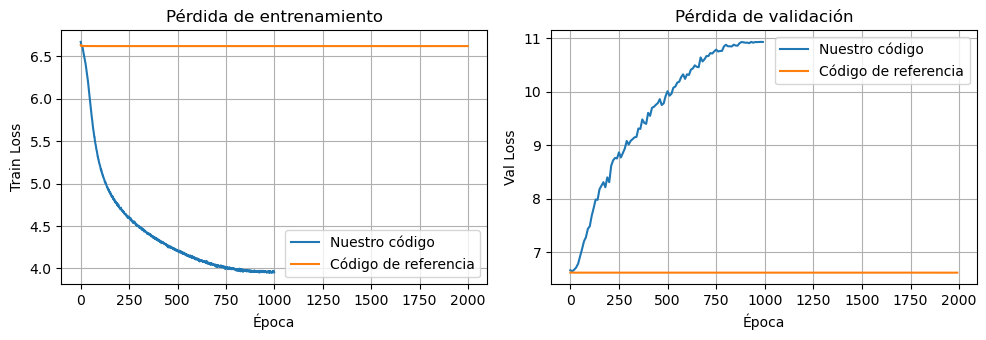

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10,3.5))

# --- Train Loss  ---
axes[0].plot(history['train_loss'], label='Nuestro código')
axes[0].plot(history_reference['train_loss'], label='Código de referencia')
axes[0].set_title('Pérdida de entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Train Loss')
axes[0].legend()
axes[0].grid(True)

# --- Validation Loss ---
axes[1].plot(np.arange(0,1000,10), history['val_loss'], label='Nuestro código')
axes[1].plot(np.arange(0,2000,10), history_reference['val_loss'], label='Código de referencia')
axes[1].set_title('Pérdida de validación')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Val Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../results/loss_comparison_refactored_vs_reference.png', dpi=300)
plt.show()
